In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import model_selection
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor

In [2]:
df1 = pd.read_pickle('')
df2 = pd.read_pickle('')
df3 = pd.read_pickle('')
df4 = pd.read_pickle('')
df = pd.concat([df1,df2,df3],axis=1)
df = df.merge(df4, on='horse_id')

In [4]:
df.drop(['タイム', '着差', '着順', '馬名', 'ﾀｲﾑ指数', '通過', '上り', '調教ﾀｲﾑ', '厩舎ｺﾒﾝﾄ', '賞金(万円)','調教師','枠番','人気','馬主', '騎手', '単勝'], axis=1, inplace=True)

In [5]:
df = df.drop_duplicates(subset=df.columns)

In [6]:
df['rightORleft'].value_counts()

右    25699
左    20163
芝     1492
直      403
Name: rightORleft, dtype: int64

In [ ]:
result = []
for i in  df['time']:
    try:
         appendResult = i.split(':')[0]
         appendResult = re.sub( r'\D+', '', appendResult)
         if(appendResult == ''):
            result.append(0)
            continue
         result.append(appendResult)
    except IndexError:
        result.append(0)
        continue
        

df['timeHour'] = result
df.drop('time', axis=1, inplace=True)

In [ ]:
result = []
for i in df['situation']:
    if(i == "良"):
        result.append(0)
    elif(i=="稍重"):
        result.append(1)
    elif(i=="重"):
        result.append(2)
    else:
        result.append(3)
df['situation'] = result

In [ ]:
result = []
for i in df['whether']:
    if(i == "晴"):
        result.append(0)
    elif(i=="曇"):
        result.append(1)
    elif(i=="雨"):
        result.append(2)
    else:
        result.append(3)
df['whether'] = result

In [ ]:
result = []
for i in df['distance']:
    result.append(re.sub( r'\D+', '', i))
df['distance'] = result
df['distance'] = df['distance'].astype(int)

In [11]:
df.loc[(df.rightORleft=='芝'), 'rightORleft'] = np.nan

In [ ]:
result = []
for i in df['track']:
    if(i == "ダ"):
        result.append(0)
    elif(i=="芝"):
        result.append(1)
    else:
        result.append(2)
df['track'] = result

In [ ]:
df['性別'] = df['性齢'].str[0]
df['年齢'] = df['性齢'].str[1:3]
df['年齢'] = df['年齢'].astype(int)
df.drop('性齢', axis=1,inplace=True)

In [ ]:
result = []
for i  in df['馬体重'].str[4:].str.replace(')','', regex=True).str[0]:
    if i=='+':
        result.append(1)
    elif i=='-':
        result.append(2)
    else:
        result.append(0)

df['加減'] = result
df['体重増減'] = df['馬体重'].str[4:].str.replace(')','', regex=True).str[1:]
df.loc[(df.体重増減 == ''), '体重増減'] = '0'
df['体重増減'] = df['体重増減'].astype(int)
df['馬体重'] = df['馬体重'].str[0:3]
# df.loc[(df.馬体重 !='計不'), ['馬体重']].astype(float).mean().round().astype(int)
df.loc[(df.馬体重=='計不'), '馬体重'] = '471'
df['馬体重'] = df['馬体重'].astype(int)


In [ ]:
result = []

for i in df['備考']:
    if i=='出遅れ':
        result.append(1)
    else:
        result.append(0)

df['出遅れ'] = result
df.drop('備考', axis=1, inplace=True)

In [16]:
# df.loc[(df.単勝=='---'), '単勝'] = 0
# df['単勝'] = df['単勝'].astype(float).round().astype(int)
# dummy = df[['単勝','性別','rightORleft']]
# dummy = pd.get_dummies(dummy)
# dummy = pd.concat([dummy, df[['斤量','馬体重', '馬番','馬体重','体重増減','加減','年齢']]], axis=1)

# known_tansyo = dummy[dummy.単勝 != 0].values  
# unknown_tansyo = dummy[dummy.単勝 == 0].values


# X = known_tansyo[:, 1:]  
# y = known_tansyo[:, 0]

# rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
# rfr.fit(X, y)

# predictedTansyo = rfr.predict(unknown_tansyo[:, 1::])
# df.loc[(df.単勝 == 0), '単勝'] = predictedTansyo.round().astype(int)

In [ ]:
df['timeHour'] = df['timeHour'].astype(int)
dummy = df[['timeHour','性別','rightORleft']]
dummy = pd.get_dummies(dummy)
dummy = pd.concat([dummy, df[['斤量','馬体重', '馬番','馬体重','体重増減','加減','年齢']]], axis=1)

known_tansyo = dummy[dummy.timeHour != 0].values  
unknown_tansyo = dummy[dummy.timeHour == 0].values


X = known_tansyo[:, 1:]  
y = known_tansyo[:, 0]

rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

predictedTansyo = rfr.predict(unknown_tansyo[:, 1::])
df.loc[(df.timeHour == 0), 'timeHour'] = predictedTansyo.round().astype(int)

In [ ]:
df['rightORleft'].fillna("右", inplace=True)

In [ ]:
df['horse_id'] = df['horse_id'].astype(int)
df['jockey_id'] = df['jockey_id'].astype(int)
df['deokureNum'] = df['deokureNum'].astype(int)
df['raceNum'] = df['raceNum'].astype(int)

In [19]:
# dummy = df[['騎手','場所','性別','調教師','馬主']]
dummy = df[['rightORleft','性別']]
dummy = pd.get_dummies(dummy)
newDf = pd.concat([df, dummy], axis=1)
newDf.drop(['rightORleft','性別'],axis=1,inplace=True)

In [21]:
newDf.dtypes

馬番                 int64
斤量               float64
馬体重                int32
track              int64
distance           int32
whether            int64
situation          int64
horse_id           int32
jockey_id          int32
deokureNum         int32
raceNum            int32
timeHour           int32
年齢                 int32
加減                 int64
体重増減               int32
出遅れ                int64
rightORleft_右      uint8
rightORleft_左      uint8
rightORleft_直      uint8
性別_セ               uint8
性別_牝               uint8
性別_牡               uint8
dtype: object

In [69]:
X = newDf.drop('出遅れ',axis=1)
y = newDf['出遅れ']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state = 42)
kfold = model_selection.KFold(n_splits = 5) 
scores = {}
lgbm_clf = LGBMClassifier(eval_metric='accuracy')
lgbm_clf.fit(X_train, y_train)
results = model_selection.cross_val_score(lgbm_clf, X_test, y_test, cv = kfold) 
scores[('lightGBM', 'train_score')] = results.mean()
scores[('lightGBM', 'test_score')] = lgbm_clf.score(X_test, y_test)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


In [70]:
pd.Series(scores).unstack()

,test_score,train_score
lightGBM,0.806114,0.793655


In [71]:
from sklearn.metrics import accuracy_score 
y_pred = lgbm_clf.predict(X_test)
accuracy_score(y_test,y_pred) 

0.8061139028475712

In [72]:
threshold = 0.5 #閾値を設定
y_pred = (lgbm_clf.predict_proba(X_test)[:,1] >= threshold).astype(int)
accuracy_score(y_test,y_pred) 

0.8061139028475712

In [50]:
count = 0
for i in y_pred:
    if i == 1:
        count = count + 1

In [67]:
import math
count = []
for i in range(len(y_pred[:50])):
    count.append((math.floor(y_pred[i][1] * 10) / 10))

(array([12., 12.,  6.,  6.,  5.,  4.,  3.,  1.,  0.,  1.]),
 array([0.  , 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ]),
 <BarContainer object of 10 artists>)

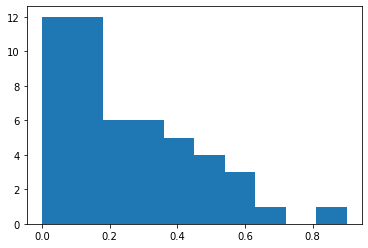

In [68]:
import numpy as np
import matplotlib.pyplot as plt
 
plt.hist(count)

In [75]:
y_pred = lgbm_clf.predict_proba(X_test[:10])
pd.DataFrame(y_pred, columns=['出遅れない','出遅れる'])

,出遅れない,出遅れる
0,0.677834,0.322166
1,0.999640,0.000360
2,0.835446,0.164554
3,0.480195,0.519805
4,0.624585,0.375415
5,0.894943,0.105057
6,0.585339,0.414661
7,0.937171,0.062829
8,0.917358,0.082642
9,0.303445,0.696555


In [25]:
X_test.columns

Index(['馬番', '斤量', '馬体重', 'track', 'distance', 'whether', 'situation',
       'horse_id', 'jockey_id', 'deokureNum', 'raceNum', 'timeHour', '年齢',
       '加減', '体重増減', 'rightORleft_右', 'rightORleft_左', 'rightORleft_直', '性別_セ',
       '性別_牝', '性別_牡'],
      dtype='object')

In [26]:
# import pickle
# filename = 'new_marge_model.pkl'
# pickle.dump(lgbm_clf,open(filename,'wb'))

In [27]:
proba = lgbm_clf.predict_proba(X_test)

In [28]:
pd.DataFrame(lgbm_clf.feature_importances_, index=X.columns).sort_values(by=0, ascending=False)[:20]

,0
raceNum,434
deokureNum,364
jockey_id,358
horse_id,350
馬体重,302
distance,243
馬番,238
体重増減,158
timeHour,135
track,87


In [30]:
#split
from sklearn.model_selection import train_test_split

#score
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

#models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import NearestCentroid,KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# データセットの読み込みや前処理などを行う

# モデルの定義
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# チューニングするパラメータとその範囲を指定
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# グリッドサーチによるハイパーパラメータのチューニング
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(xgb_model, parameters, scoring='roc_auc', cv=kfold)
clf.fit(X_train, y_train)

# 最適なハイパーパラメータの取得
print("Best parameters: ", clf.best_params_)

# テストデータで評価
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Best parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 80.50%


In [41]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=2, loss_function='Logloss')
model.fit(X_train, y_train)

# テストセットでのモデルの評価
print("Accuracy on test set:", model.score(X_test, y_test))

0:	learn: 0.6212945	total: 141ms	remaining: 13.9s
1:	learn: 0.5943723	total: 144ms	remaining: 7.06s
2:	learn: 0.5723458	total: 147ms	remaining: 4.76s
3:	learn: 0.5514525	total: 151ms	remaining: 3.61s
4:	learn: 0.5365959	total: 154ms	remaining: 2.93s
5:	learn: 0.5239001	total: 158ms	remaining: 2.47s
6:	learn: 0.5129462	total: 161ms	remaining: 2.14s
7:	learn: 0.5053286	total: 165ms	remaining: 1.89s
8:	learn: 0.4976424	total: 168ms	remaining: 1.7s
9:	learn: 0.4940606	total: 171ms	remaining: 1.54s
10:	learn: 0.4887486	total: 175ms	remaining: 1.42s
11:	learn: 0.4850944	total: 179ms	remaining: 1.31s
12:	learn: 0.4810402	total: 182ms	remaining: 1.22s
13:	learn: 0.4785949	total: 186ms	remaining: 1.14s
14:	learn: 0.4765604	total: 190ms	remaining: 1.08s
15:	learn: 0.4733312	total: 194ms	remaining: 1.02s
16:	learn: 0.4716031	total: 197ms	remaining: 962ms
17:	learn: 0.4690695	total: 202ms	remaining: 919ms
18:	learn: 0.4671348	total: 206ms	remaining: 877ms
19:	learn: 0.4659643	total: 210ms	remainin

In [44]:
from sklearn.ensemble import VotingClassifier

lgbm = lgbm_clf
xgb = clf
catboost = model

# アンサンブル用のモデルを作成
ensemble = VotingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb), ('catboost', catboost)], voting='soft')

# 各モデルをトレーニング
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 各モデルでの予測
lgbm_preds = lgbm.predict_proba(X_test)
xgb_preds = xgb.predict_proba(X_test)
catboost_preds = catboost.predict_proba(X_test)

ensemble.fit(X_train, y_train)
# アンサンブルモデルでの予測
ensemble_preds = ensemble.predict_proba(X_test)

# 各モデルの精度を出力
print("LightGBM accuracy:", accuracy_score(y_test, np.argmax(lgbm_preds, axis=1)))
print("XGBoost accuracy:", accuracy_score(y_test, np.argmax(xgb_preds, axis=1)))
print("CatBoost accuracy:", accuracy_score(y_test, np.argmax(catboost_preds, axis=1)))

# アンサンブルモデルの精度を出力
print("Ensemble accuracy:", accuracy_score(y_test, np.argmax(ensemble_preds, axis=1)))

0:	learn: 0.6212945	total: 5.46ms	remaining: 541ms
1:	learn: 0.5943723	total: 9.89ms	remaining: 485ms
2:	learn: 0.5723458	total: 14.2ms	remaining: 460ms
3:	learn: 0.5514525	total: 18.6ms	remaining: 446ms
4:	learn: 0.5365959	total: 22.8ms	remaining: 434ms
5:	learn: 0.5239001	total: 27.3ms	remaining: 428ms
6:	learn: 0.5129462	total: 32.1ms	remaining: 426ms
7:	learn: 0.5053286	total: 36.6ms	remaining: 421ms
8:	learn: 0.4976424	total: 40.8ms	remaining: 412ms
9:	learn: 0.4940606	total: 44.8ms	remaining: 404ms
10:	learn: 0.4887486	total: 49.6ms	remaining: 401ms
11:	learn: 0.4850944	total: 53.8ms	remaining: 394ms
12:	learn: 0.4810402	total: 57.7ms	remaining: 386ms
13:	learn: 0.4785949	total: 62.1ms	remaining: 381ms
14:	learn: 0.4765604	total: 66.1ms	remaining: 375ms
15:	learn: 0.4733312	total: 70.2ms	remaining: 368ms
16:	learn: 0.4716031	total: 73.7ms	remaining: 360ms
17:	learn: 0.4690695	total: 77.8ms	remaining: 355ms
18:	learn: 0.4671348	total: 82.3ms	remaining: 351ms
19:	learn: 0.4659643	t

In [46]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
# LightGBMのモデルを定義する
lgb_model = lgb.LGBMClassifier()

# ハイパーパラメータの範囲を定義する
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 63, 127],
}

# グリッドサーチを実行する
lgb_grid = GridSearchCV(lgb_model, param_grid, cv=5)
lgb_grid.fit(X_train, y_train)

# 最適なハイパーパラメータを出力する
print("Best parameters: ", lgb_grid.best_params_)

# 最適なハイパーパラメータを使用してモデルをトレーニングする
best_lgb = lgb.LGBMClassifier(**lgb_grid.best_params_)
best_lgb.fit(X_train, y_train)

# テストデータでの予測を行う
y_pred = best_lgb.predict(X_test)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}


In [47]:
# LightGBMモデルを定義する
lgb_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31)

# モデルをトレーニングする
lgb_model.fit(X_train, y_train)

# テストデータでの予測を行う
y_pred = lgb_model.predict(X_test)

In [50]:
y_pred = lgb_model.predict(X_test)
accuracy_score(y_test,y_pred) 

0.8041247906197655

In [51]:
from keras.models import Sequential
from keras.layers import Dense

# MLPモデルを定義する
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# モデルをコンパイルする
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# モデルをトレーニングする
model.fit(X_train, y_train, epochs=100, batch_size=32)

# テストデータでの予測を行う
y_pred = model.predict(X_test)

Epoch 1/100
1194/1194 [==============================] - 2s 775us/step - loss: 2597782.5000 - accuracy: 0.6421
Epoch 2/100
1194/1194 [==============================] - 1s 713us/step - loss: 1995729.6250 - accuracy: 0.6398
Epoch 3/100
1194/1194 [==============================] - 1s 695us/step - loss: 1714872.6250 - accuracy: 0.6425
Epoch 4/100
1194/1194 [==============================] - 1s 709us/step - loss: 1444196.6250 - accuracy: 0.6375
Epoch 5/100
1194/1194 [==============================] - 1s 690us/step - loss: 1235498.0000 - accuracy: 0.6445
Epoch 6/100
1194/1194 [==============================] - 1s 696us/step - loss: 1287774.6250 - accuracy: 0.6425
Epoch 7/100
1194/1194 [==============================] - 1s 705us/step - loss: 1180922.6250 - accuracy: 0.6452
Epoch 8/100
1194/1194 [==============================] - 1s 692us/step - loss: 1071616.2500 - accuracy: 0.6407
Epoch 9/100
1194/1194 [==============================] - 1s 711us/step - loss: 844379.6875 - accuracy: 0.6410
Ep

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# モデルの定義
def create_model(neurons=1, dropout=0.0, lr=0.01):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# ハイパーパラメータの範囲を指定
param_grid = {'neurons': [4, 8, 16, 32, 64],
              'dropout': [0.0, 0.1, 0.2, 0.3, 0.4],
              'lr': [0.01, 0.001, 0.0001]}

# グリッドサーチを実行
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X, y)

# 結果を表示
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# パラメータの設定
dropout = 0.0
lr = 0.01
neurons = 4
input_size = 10 
num_epochs = 50


# モデルの定義
input_shape = (X_train.shape[1],)  # 入力の次元数を取得
model = keras.Sequential()
model.add(Dense(neurons, activation='relu', input_shape=input_shape))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
optimizer = keras.optimizers.Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# モデルの学習
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

# モデルの評価
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [70]:
from sklearn.ensemble import VotingClassifier

lgbm = lgbm_clf
xgb = clf
# catboost = model
nn = model

# アンサンブル用のモデルを作成
ensemble = VotingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb)], voting='soft')

# 各モデルをトレーニング
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
# nn.fit(X_train, y_train)

# 各モデルでの予測
lgbm_preds = lgbm.predict_proba(X_test)
xgb_preds = xgb.predict_proba(X_test)
# nn_preds = nn.predict(X_test)

ensemble.fit(X_train, y_train)
# アンサンブルモデルでの予測
ensemble_preds = ensemble.predict_proba(X_test)

# 各モデルの精度を出力
print("LightGBM accuracy:", accuracy_score(y_test, np.argmax(lgbm_preds, axis=1)))
print("XGBoost accuracy:", accuracy_score(y_test, np.argmax(xgb_preds, axis=1)))
# print("ニューラルネット accuracy:", accuracy_score(y_test, np.argmax(nn_preds, axis=1)))


# アンサンブルモデルの精度を出力
print("Ensemble accuracy:", accuracy_score(y_test, np.argmax(ensemble_preds, axis=1)))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
LightGBM accuracy: 0.8061139028475712
XGBoost accuracy: 0.804962311557789
Ensemble accuracy: 0.8053810720268006


In [74]:
import pickle
filename = 'ensemble.pkl'
pickle.dump(ensemble,open(filename,'wb'))

In [127]:
d

,馬番,斤量,馬体重,track,rightORleft,distance,whether,situation,horse_id,jockey_id,deokureNum,raceNum,timeHour,性別,年齢,加減,体重増減,出遅れ
0,9,52.0,474,1,右,1200,2,0,2018105875,1181,0,9,9,牝,3,2,22,0
1,5,50.0,474,1,右,1200,1,0,2018105875,1181,0,9,14,牝,3,0,0,0
2,16,53.0,496,1,左,1200,0,0,2018105875,1176,0,9,12,牝,3,0,0,0
3,7,53.0,476,1,左,1400,1,0,2018105875,1122,0,9,16,牝,3,1,2,0
4,2,53.0,478,1,右,1400,0,0,2018105875,1032,0,9,13,牝,3,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47753,11,56.0,464,0,右,1000,1,2,2018106080,1125,1,1,12,牡,3,0,0,1
47754,1,55.0,498,1,右,2000,0,0,2018105848,1178,1,11,11,牡,3,0,0,1
47755,10,54.0,486,1,右,1800,1,0,2019104476,1126,1,7,12,牡,2,0,0,0
47756,12,54.0,474,1,右,1800,1,0,2019100665,732,0,4,12,牡,2,0,0,0


In [141]:
save = X_train.copy()
save = save[['jockey_id', 'deokureNum', 'raceNum', '馬体重', '体重増減', '馬番', '加減']]

In [143]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
model = lgb.LGBMClassifier(objective='binary', random_state=42)

param_dist = {
    'num_leaves': [31, 63, 127],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

clf = RandomizedSearchCV(model, param_distributions=param_dist, cv=5, n_iter=10, scoring='accuracy')
clf.fit(save, y_train)

print('Best params:', clf.best_params_)
aaa = X_test.copy()
aaa = aaa[['jockey_id', 'deokureNum', 'raceNum', '馬体重', '体重増減', '馬番', '加減']]
y_pred = clf.predict(aaa)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 127, 'n_estimators': 1000, 'min_child_samples': 30, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Accuracy: 0.7980527638190955


In [120]:
print("Best params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 63, 'n_estimators': 1000, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1} Accuracy: 0.7990996649916248")

Best params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 63, 'n_estimators': 1000, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1} Accuracy: 0.7990996649916248


In [ ]:
import seaborn as sns
sns.heatmap(round(save.corr(),1), vmax=1, vmin=-1, center=0,annot=True)

In [136]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = save.columns
vif_data

,feature
0,jockey_id
1,deokureNum
2,raceNum
3,馬体重
4,体重増減
5,馬番
6,加減


In [137]:
vif_data["VIF"] = [variance_inflation_factor(save.values, i) for i in range(len(save.columns))]
vif_data

,feature,VIF
0,jockey_id,2.623188
1,deokureNum,2.141252
2,raceNum,5.203846
3,馬体重,11.009495
4,体重増減,2.364494
5,馬番,4.020450
6,加減,3.833510
